In [1]:
import os
import glob
import collections

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')


import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from attentionVis import AttentionVis
from trainer import Trainer, TrainerConfig
from utils import set_seed


from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from utils import print_full
from scipy.ndimage.filters import gaussian_filter, uniform_filter


import matplotlib.pyplot as plt
from utils import *
from visualize import *
set_plot_params()
%matplotlib inline
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"


# for i in {1..10}; do python3 -m gather_atts.py; done

/opt/conda/envs/neuroformer/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/neuroformer/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/tmp/ipykernel_63956/1676056690.py:41: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter, uniform_filter
/tmp/ipykernel_63956/1676056690.py:41: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter, uni

: 

In [ ]:
""" 

-- DATA --
neuroformer/data/OneCombo3_V1AL/
df = response
video_stack = stimulus
DOWNLOAD DATA URL = https://drive.google.com/drive/folders/1jNvA4f-epdpRmeG9s2E-2Sfo-pwYbjeY?usp=sharing

-- MODEL --
model_dir = neuroformer/moodels/<downloaded folder>
DOWNLOAD_MODEL_URL = https://drive.google.com/drive/folders/18SmliXt0tcC7spooB8Nyx3n79t3vBFR8?usp=sharing
specify the downloaded folder directory above to MODEL_DIR

"""

RESPONSE_PATH = "./data/Combo3_V1AL/Combo3_V1AL_response.csv"
STIMULUS_PATH = "./data/Combo3_V1AL/Combo3_V1AL_stimulus.pt"

MODEL_DIR = "/home/antonis/projects/slab/git/neuroformer/models/tensorboard/V1_AL/test_2/shuffled_False/w:0.05_wp:0.2"


df = pd.read_csv(RESPONSE_PATH)
video_stack = torch.load(STIMULUS_PATH)

In [24]:
model_dir = MODEL_DIR

model_path = glob.glob(os.path.join(model_dir, "*.pt"))[0]
mconf_path = glob.glob(os.path.join(model_dir, "*_mconf.pkl"))[0]
tconf_path = glob.glob(os.path.join(model_dir, "*_tconf.pkl"))[0]

with open(mconf_path, 'rb') as handle:
    mconf = pickle.load(handle)
with open(tconf_path, 'rb') as handle:
    tconf = pickle.load(handle)

torch.Size([3, 640, 1, 64, 112])


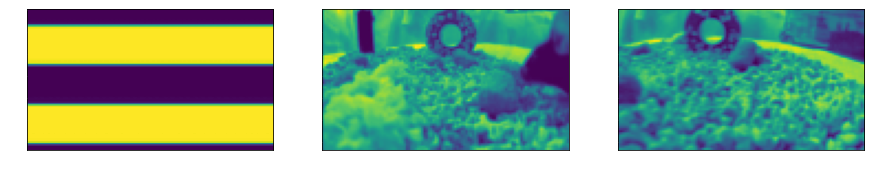

In [25]:
print(video_stack.shape)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(video_stack[i, 1, 0].permute(0, 1))

In [26]:
window = mconf.window
window_prev = mconf.window_prev
dt = mconf.dt

df['Interval'] = make_intervals(df, window)

max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)]
df['Time'] = df['Time'].round(4)

In [27]:
from SpikeVidUtils import SpikeTimeVidData2

## qv-vae feats
# frames = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_code_feats-24-05-4x4x4.pt").numpy() + 2
# frame_feats = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_embed_feats-24-05-4x4x4.pt").numpy()
# frame_block_size = frames.shape[-1] - 1

## resnet3d feats
kernel_size = (10, 8, 8)
n_embd = 256
n_embd_frames = 64
frame_feats = video_stack

frame_block_size = ((20 // kernel_size[0] * 64 * 112) // (n_embd_frames))
# frame_block_size = 5 * 14 * 14
frame_feats = video_stack.transpose(1, 2)

# frame_block_size = 560
prev_id_block_size = 30
id_block_size = 30   # 95
block_size = frame_block_size + id_block_size + prev_id_block_size # frame_block_size * 2  # small window for faster training
frame_memory = 20   # how many frames back does model see

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

# translate neural embeddings to separate them from ID embeddings
# frames = frames + [*id_stoi.keys()][-1] 
# neurons = [i for i in range(df['ID'].min(), df['ID'].max() + 1)]
neurons = sorted(list(set(df['ID'].unique())))
# pixels = sorted(np.unique(frames).tolist())
trial_tokens = [f"Trial {n}" for n in df['Trial'].unique()]
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }
max(list(itos_dt.values()))

0.2

In [28]:
"""
Set environment variables from mconf and tconf
"""

for a in dir(tconf):
    if not a.startswith('__'):
        globals()[a] = getattr(tconf, a)
for a in dir(mconf):
    if not a.startswith('__'):
        globals()[a] = getattr(mconf, a)


In [29]:
# train_len = round(len(df)*(4/5))
# test_len = round(len(df) - train_len)

# train_data = df[:train_len]
# test_data = df[train_len:train_len + test_len].reset_index().drop(['index'], axis=1)

n = []
n_trial = [2, 8, 14, 19]
for n_stim in range(df['Trial'].max() // 20):
    # n_trial = [2, 4, 6, 8, 10, 12, 14, 18]
    for n_t in n_trial:
        trial = (n_stim + 1) * 20 - (n_t)
        n.append(trial)
train_data = df[~df['Trial'].isin(n)].reset_index(drop=True)
test_data = df[df['Trial'].isin(n)].reset_index(drop=True)
small_data = df[df['Trial'].isin([5])].reset_index(drop=True)

In [30]:
from SpikeVidUtils import SpikeTimeVidData2

# train_dat1aset = spikeTimeData(spikes, block_size, dt, stoi, itos)

train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False, window_prev=window_prev, frame_window=frame_window)
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False, window_prev=window_prev, frame_window=frame_window)
# dataset = SpikeTimeVidData(df, frames, frame_feats, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos)
# single_batch = SpikeTimeVidData(df[df['Trial'].isin([5])], None, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats)
small_dataset = SpikeTimeVidData2(small_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False, window_prev=window_prev, frame_window=frame_window)


print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')

Length: 44784 Neurons: 389 Pixels: 0.
id block size: 30
frames: 224, id: 30
0.1
Length: 12420 Neurons: 389 Pixels: 0.
id block size: 30
frames: 224, id: 30
0.1
Length: 699 Neurons: 389 Pixels: 0.
id block size: 30
frames: 224, id: 30
0.1
train: 18956, test: 4980


In [31]:
"""

Load Model

"""

from model_neuroformer import GPT

model = GPT(mconf)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

57344


<All keys matched successfully>

In [32]:
"""

RUN SIMULATION

"""


from utils import *
from IPython.utils import io
# top_p=0.25, top_p_t=0.9, temp=2.

# for idx in range(len(df_pred['ID'])):
#     df_pred['ID'][idx] = itos[df_pred['ID'][idx]]

# model_path = "/home/antonis/projects/slab/git/neuroformer/models/tensorboard/V1_AL_modalities/cont_weighted/25_Cont:True_0.50.1_sparseFalse_conv_True_shuffle:True_batch:224_sparse_(None_None)_pos_emb:False_temp_emb:True_drop:0.2_dt:True_2.0_0.5_max0.1_(4, 4, 6)_2_256_nembframe64.pt"
# model_path = "/Users/antonis/Downloads/[16, 17, 18, 19]_Cont_True_0.50.05_sparseFalse_conv_True_shuffle_True_batch_224_sparse_(None_None)_pos_emb_False_temp_emb_True_drop_0.2_dt_True_2.0_0.5_max0.05_(4, 0, 6)_2_256_nembframe64-2.pt"
# model_path = "/Users/antonis/projects/slab/neuroformer/neuroformer/models/tensorboard/V1_AL/sos_clip/25_Cont:True_0.50.1_sparseFalse_conv_True_shuffle:True_batch:96_sparse_(200_4)_pos_emb:False_temp_emb:True_drop:0.2_dt:True_2.0_0.5_max0.1_(2, 2, 2)_2_256_nembframe64_(20, 8, 8).pt"
model.load_state_dict(torch.load(model_path, map_location='cpu'))

# trials = np.random.choice(train_data['Trial'].unique(), size=12)
# trials = test_data['Trial'].unique()
trials = train_data['Trial'].unique()[::4]
# trials = train_data['Trial'].unique()
# trials = train_data['Trial'].unique()[::4]

# trials = [start + (i * 20) for i in range(3)]
# trials = df['Trial'].unique()[0::20] 
results_dict = dict()
# for n in range(2, 20):
df_pred = None
df_true = None
n_p = 0.3   # (n + 1) * 0.05
temp = 2
# stoi['SOS'] = 2000
for trial in trials:    # test_data['Trial'].unique():
    # with io.capture_output() as captured:
        print(f"Trial: {trial}")
        df_trial = df[df['Trial'] == trial]
        trial_dataset = SpikeTimeVidData2(df_trial, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                          window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, 
                                          pred=False, window_prev=window_prev, frame_window=frame_window)
        trial_loader = DataLoader(trial_dataset, shuffle=False, pin_memory=False)
        results_trial = predict_raster_recursive_time_auto(model, trial_loader, window, window_prev, stoi, itos_dt, itos=itos, sample=True, top_p=0.75, top_p_t=0.75, temp=1.3, temp_t=1.3, frame_end=0, get_dt=True, gpu=False, pred_dt=True)
        # results_trial = predict_raster_hungarian(model, loader, itos_dt, top_p=0.75, temp=1)
        # print(f"MAX ID ---- {sorted(results_trial['ID'].unique()[-10])}")
        df_trial_pred, df_trial_true = process_predictions(results_trial, stoi, itos, window)
        print(f"pred: {df_trial_pred.shape}, true: {df_trial_true.shape}" )
        if df_pred is None:
            df_pred = df_trial_pred
            df_true = df_trial_true
        else:
            df_pred = pd.concat([df_pred, df_trial_pred])
            df_true = pd.concat([df_true, df_trial_true])

# df_preds[n] = df_pred
# print(f"--- n: {n}, n_p: {n_p}, temp: {temp} ---")
scores = compute_scores(df[df['Trial'].isin(trials)], df_pred)
print(scores)
print(f"pred: {len(df_pred)}, true: {len(df_true)}" )
# results_dict[n] = (scores)


len pred: 8, len true: 16:   1%|          | 4/361 [00:00<00:10, 32.71it/s]

Trial: 2
Length: 766 Neurons: 389 Pixels: 0.
id block size: 30
frames: 224, id: 30
0.15


len pred: 8, len true: 17:   1%|          | 3/394 [00:00<00:14, 27.86it/s]

pred: (466, 5), true: (685, 2)
Trial: 7
Length: 889 Neurons: 389 Pixels: 0.
id block size: 30
frames: 224, id: 30
0.15


len pred: 7, len true: 15:   1%|          | 4/347 [00:00<00:09, 37.35it/s]

pred: (505, 5), true: (848, 2)
Trial: 11
Length: 693 Neurons: 389 Pixels: 0.
id block size: 30
frames: 224, id: 30
0.15


len pred: 6, len true: 12:   1%|          | 4/382 [00:00<00:10, 36.60it/s]

pred: (437, 5), true: (634, 2)
Trial: 16
Length: 991 Neurons: 389 Pixels: 0.
id block size: 30
frames: 224, id: 30
0.2


len pred: 10, len true: 20:   1%|          | 3/479 [00:00<00:19, 24.26it/s]

pred: (526, 5), true: (926, 2)
Trial: 22
Length: 1782 Neurons: 389 Pixels: 0.
id block size: 30
frames: 224, id: 30
0.15


len pred: 9, len true: 22:   1%|          | 4/392 [00:00<00:10, 37.34it/s]

pred: (1019, 5), true: (1642, 2)
Trial: 27
Length: 933 Neurons: 389 Pixels: 0.
id block size: 30
frames: 224, id: 30
0.2


len pred: 9, len true: 15:   1%|          | 4/480 [00:00<00:13, 35.70it/s]

pred: (716, 5), true: (866, 2)
Trial: 31
Length: 1429 Neurons: 389 Pixels: 0.
id block size: 30
frames: 224, id: 30
0.15


len pred: 7, len true: 18:   1%|          | 4/389 [00:00<00:10, 35.24it/s]

pred: (970, 5), true: (1321, 2)
Trial: 36
Length: 864 Neurons: 389 Pixels: 0.
id block size: 30
frames: 224, id: 30
0.2


len pred: 9, len true: 40:   1%|          | 4/456 [00:00<00:11, 38.93it/s]

pred: (942, 5), true: (791, 2)
Trial: 42
Length: 1173 Neurons: 389 Pixels: 0.
id block size: 30
frames: 224, id: 30
0.2


len pred: 8, len true: 19:   1%|          | 4/402 [00:00<00:10, 36.84it/s]

pred: (816, 5), true: (1064, 2)
Trial: 47
Length: 816 Neurons: 389 Pixels: 0.
id block size: 30
frames: 224, id: 30
0.15


len pred: 6, len true: 13:   1%|          | 4/386 [00:00<00:10, 37.77it/s]

pred: (667, 5), true: (759, 2)
Trial: 51
Length: 799 Neurons: 389 Pixels: 0.
id block size: 30
frames: 224, id: 30
0.2


len pred: 8, len true: 18:   1%|          | 4/395 [00:00<00:10, 37.95it/s]

pred: (675, 5), true: (759, 2)
Trial: 56
Length: 794 Neurons: 389 Pixels: 0.
id block size: 30
frames: 224, id: 30
0.2


len pred: 667, len true: 1146: 100%|██████████| 395/395 [00:13<00:00, 28.48it/s]


pred: (666, 5), true: (751, 2)
defaultdict(<class 'list'>, {'precision': 0.0015856621516609122, 'recall': 0.001347452153070827, 'F1': 0.0013579309522661043})
pred: 8405, true: 11046


In [33]:
"""

Split data into full-stimulus trials

"""


t_1, t_2 = 35, 36
trial_data_1 = df[df['Trial'] == t_1]
trial_dataset_1 = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False, window_prev=window_prev)
trial_loader_1 = DataLoader(trial_dataset_1, shuffle=False, pin_memory=False)

def loader_trial(df, n_trial):
    trial_data = df[df['Trial'] == n_trial]
    trial_dataset = SpikeTimeVidData2(trial_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False, window_prev=window_prev)
    trial_loader = DataLoader(trial_dataset, shuffle=False, pin_memory=False)
    return trial_loader

trial_data_1 = loader_trial(df, t_1)
trial_data_2 = loader_trial(df, t_2)

iterable1 = iter(trial_data_1)
iterable2 = iter(trial_data_2)

# train_len = round(len(df)*(4/5))
# test_len = round(len(df) - train_len)

# train_data = df[:train_len]
# test_data = df[train_len:train_len + test_len].reset_index().drop(['index'], axis=1)
n_trial = [2, 8, 14, 19]

n_1 = []
for n_stim in range(3): # range(df['Trial'].max() // 20):
    for n_t in n_trial:
        trial = (n_stim + 1) * 20 - (n_t - 2)
        n_1.append(trial)
test2_data = df[df['Trial'].isin(n_1)].reset_index(drop=True)
small_data = df[df['Trial'].isin([5])].reset_index(drop=True)


n_2 = []
for n_stim in range(3): # range(df['Trial'].max() // 20):
    for n_t in n_trial:
        trial = (n_stim + 1) * 20 - (n_t - 1)
        n_2.append(trial)
test3_data = df[df['Trial'].isin(n_2)].reset_index(drop=True)
# small_data = df[df['Trial'].isin([5])].reset_index(drop=True)

print(f"trials: {test2_data['Trial'].unique()}")
print(f"trials: {test3_data['Trial'].unique()}")

from analysis import *
from utils import *
from SpikeVidUtils import create_full_trial

# df_1 = df_pred[df_pred['ID'] < stoi['SO`S']].reset_index(drop=True)
# df_2 = test_data[test_data['Trial'].isin(trials)].reset_index(drop=True)

# df_1 = df[df['Trial'].isin(range(10))]
# df_2 = df[df['Trial'].isin(range(11, 20))]

df_pred_full = create_full_trial(df_pred)
df_1 = create_full_trial(df, trials)
df_2 = create_full_trial(df, n_1)
df_3 = create_full_trial(df, n_2)

# df_2['Interval'] += 0.5
# df_pred_full['Interval'] += 0.5

# df_1 = create_full_trial(df, t_trial=t_trial, n_start=df_pred['Trial'].min(), n_stim=3, n_step=20, n_trials=10)
# df_2 = create_full_trial(df, t_trial=t_trial, n_start=df_pred['Trial'].min() + 1, n_stim=3, n_step=20, n_trials=10)
# df_3 = create_full_trial(df, t_trial=t_trial, n_start=df_pred['Trial'].min() + 2, n_stim=3, n_step=20, n_trials=10)

# df_1 = df_1[(df_1['Interval'].isin(df_pred_full['Interval'].unique()))].reset_index(drop=True)
# df_2 = df_2[(df_2['Interval'].isin(df_pred_full['Interval'].unique()))].reset_index(drop=True)
# df_3 = df_3[(df_3['Interval'].isin(df_pred_full['Interval'].unique()))].reset_index(drop=True)

window_pred = None

df_list = [df_pred_full, df_1, df_2, df_3]

for df_ in df_list:
    window_pred = 0.5
    df_['Interval'] = make_intervals(df_, window_pred)

window_pred = window if window_pred is None else window_pred
intervals = np.array(sorted(set(df['Interval'].unique()) & set(df['Interval'].unique())))
labels = np.array([round(window_pred + window_pred*n, 2) for n in range(0, int(max(df_pred_full['Interval']) / window_pred))])
ids = sorted(set(df['ID'].unique()) & set(df['ID'].unique()))


# labels = sorted(set(df_pred_full['Interval'].unique()))
rates_pred = get_rates_trial(df_pred_full, labels)
rates_1 = get_rates_trial(df_1, labels)
rates_2 = get_rates_trial(df_2, labels)
rates_3 = get_rates_trial(df_3, labels)

top_corr_pred = calc_corr_psth(rates_pred, rates_1)
top_corr_real = calc_corr_psth(rates_1, rates_2)
top_corr_real_2 = calc_corr_psth(rates_1, rates_3)

Length: 44784 Neurons: 389 Pixels: 0.
id block size: 30
frames: 224, id: 30
0.1
Length: 1547 Neurons: 389 Pixels: 0.
id block size: 30
frames: 224, id: 30
0.1
Length: 864 Neurons: 389 Pixels: 0.
id block size: 30
frames: 224, id: 30
0.2
trials: [ 3  8 14 20 23 28 34 40 43 48 54 60]
trials: [ 2  7 13 19 22 27 33 39 42 47 53 59]


id_pred: 384, id_true_1: 386, id_true_2: 386
len_pred: 8405, len_true: 11929
real: defaultdict(<class 'list'>, {'precision': 0.37685905780278683, 'recall': 0.35030421229545144, 'F1': 0.35269676140414213})
pred: defaultdict(<class 'list'>, {'precision': 0.4143446447175934, 'recall': 0.308981527779612, 'F1': 0.34798317434782566})
386


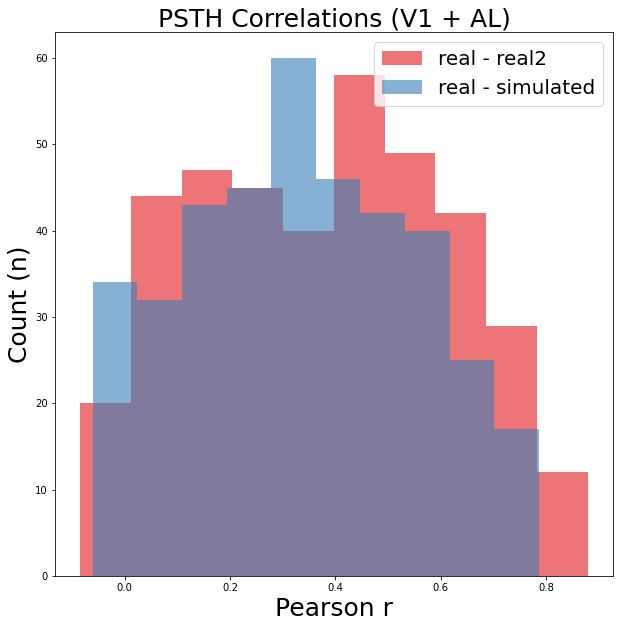

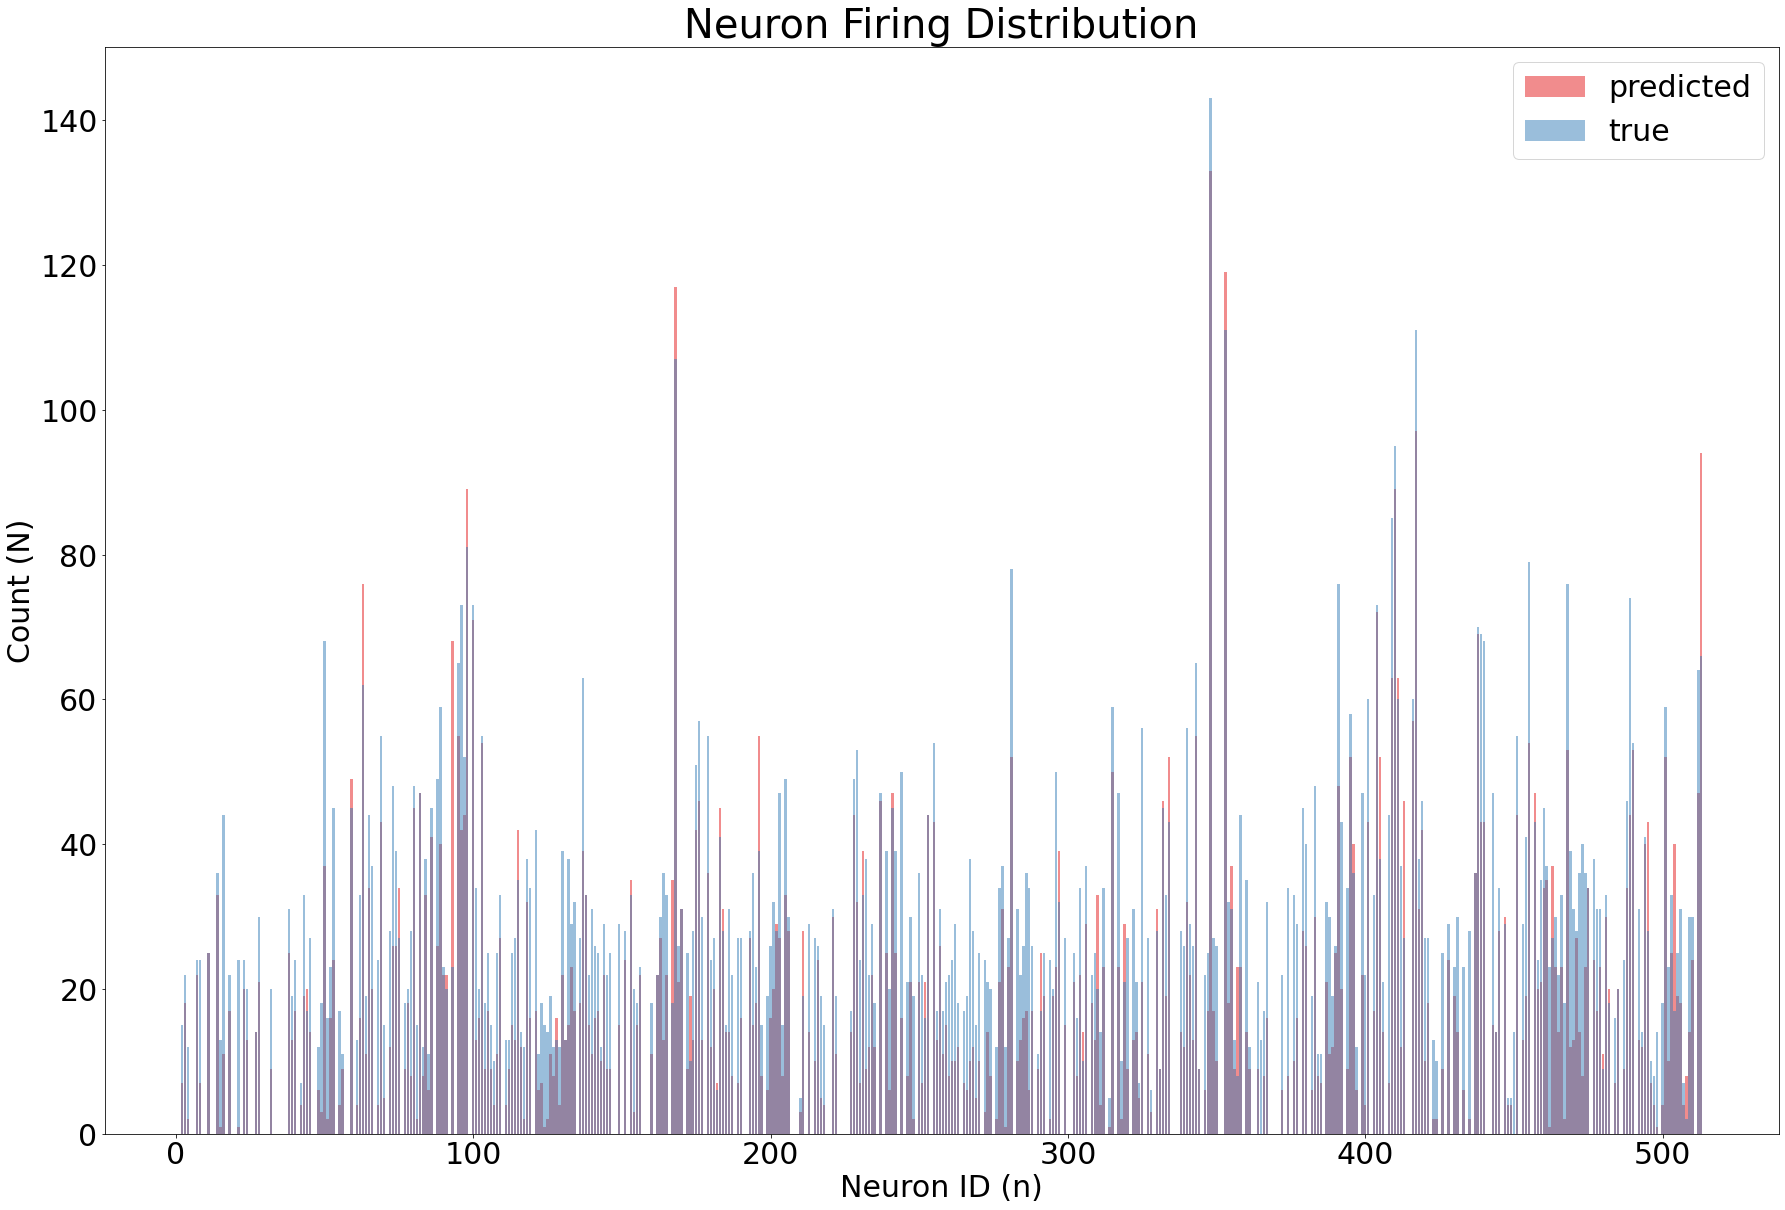

In [34]:
"""

Evaluate results

"""



from visualize import *

# df_2['Trial'] -= 2
id_pred, id_true_1, id_true_2 = len(df_pred_full['ID'].unique()), len(df_1['ID'].unique()), len(df_2['ID'].unique())
print(f"id_pred: {id_pred}, id_true_1: {id_true_1}, id_true_2: {id_true_2}")

len_pred, len_true = len(df_pred_full), len(df_1)
print(f"len_pred: {len_pred}, len_true: {len_true}")

accuracy = get_accuracy(df_pred, df_2)

scores = compute_scores(df_1, df_2)
pred_scores = compute_scores(df_1, df_pred_full)
print(f"real: {scores}")
print(f"pred: {pred_scores}")

set_plot_white()
plt.figure(figsize=(10, 10), facecolor='white')
plt.title('PSTH Correlations (V1 + AL)', fontsize=25)
plt.ylabel('Count (n)', fontsize=25)
plt.xlabel('Pearson r', fontsize=25)
plt.hist(top_corr_real, label='real - real2', alpha=0.6)
# plt.hist(top_corr_real_2, label='real - real3', alpha=0.6)
plt.hist(top_corr_pred, label='real - simulated', alpha=0.6)
plt.legend(fontsize=20)

dir_name = os.path.dirname(model_path)
plt.savefig(os.path.join(dir_name, 'psth_corr.svg'))

plot_distribution(df_1, df_pred)

total_scores = dict()
total_scores['real'] = scores
total_scores['pred'] = pred_scores